# Picnic Hackathon 🥇✅💯
 **When great customer support meets data**


## Why the challenge?
One of our core beliefs is to offer our customers the best support possible, by allowing them, for example, to send in pictures of defect products they wish to be reimbursed for. But processing these pictures is very time-consuming as it is all done manually.

## What is the challenge?
The challenge we propose is the following: As a first step in helping customer support, come up with a way of labeling every picture that comes in according to the product that is in the picture. To keep with the Picnic spirit, we encourage to be as innovative and creative with your solutions as possible.

## Dataset
To that end, we offer the following [dataset](https://github.com/Younes-Charfaoui/Picnic-Hackathon/blob/master/images/picnic_logo.png) of pictures of defect items.

## Setting & Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from keras.models import Sequential
from keras.layers import Dropout,Conv2D, MaxPooling2D, Activation, Dense, Flatten
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
import glob
import os
import cv2

Using TensorFlow backend.


In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path_to_folder = 'gdrive/My Drive/Dataset/The Picnic Hackathon 2019/'

In [0]:
df = pd.read_csv(path_to_folder + "train.tsv",  sep='\t')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


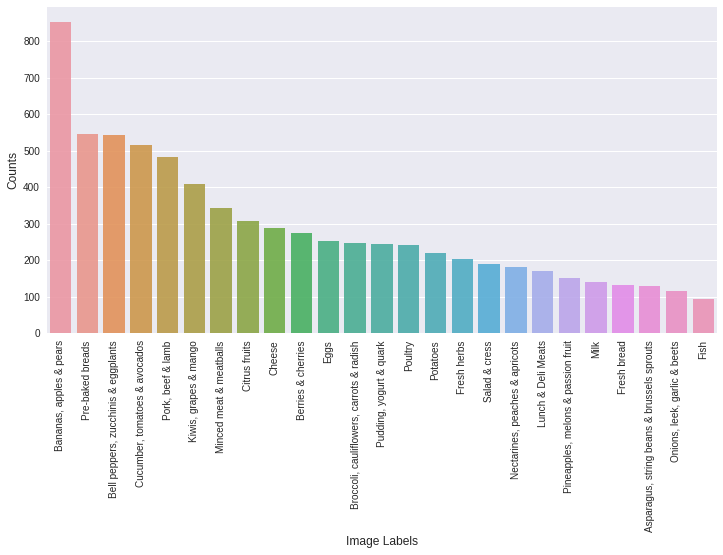

In [6]:
# getting the count of each class
label_counts = df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [0]:
# spliting the dataframe
valid_df = df.iloc[:1000 ,:]
test_df = df.iloc[1000:1400 ,:]
train_df = df.iloc[1400: ,:]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


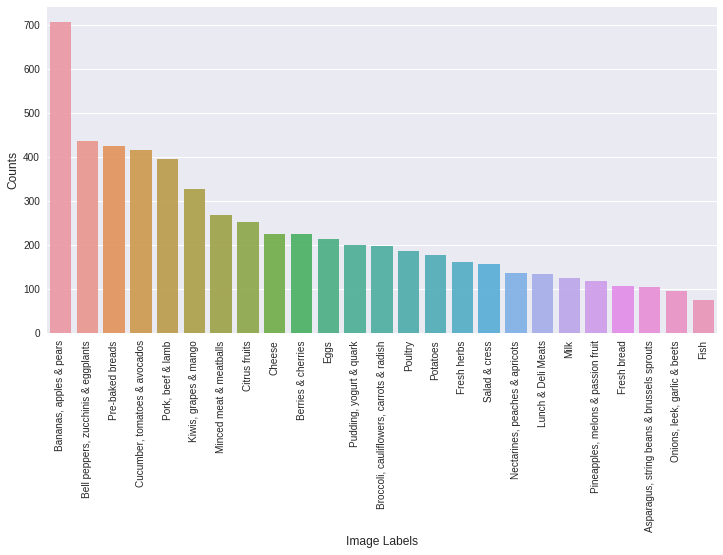

In [10]:
# getting the count of each class
label_counts = train_df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [0]:
train_gen = ImageDataGenerator(rescale=1./255, 
                               zoom_range=0.3, 
                               rotation_range=50,
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               horizontal_flip=True, 
                               fill_mode='nearest')

valid_gen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_gen.flow_from_dataframe(dataframe= train_df, directory= "gdrive/My Drive/train/", 
                                              x_col= "file", y_col= "label", 
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 64)

valid_generator = valid_gen.flow_from_dataframe(dataframe= valid_df, directory= "gdrive/My Drive/train/", 
                                              x_col= "file", y_col= "label", 
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 64)

Found 5858 images belonging to 25 classes.
Found 1000 images belonging to 25 classes.


In [0]:
step_epochs = train_generator.n // train_generator.batch_size

step_validation = valid_generator.n // valid_generator.batch_size

In [0]:
labels = train_generator.class_indices
labels = {v: k for k, v in labels.items()}

In [16]:
print(labels)

25

In [0]:
"""X_list, y_list = [], []
size = train_generator.n//train_generator.batch_size
print(size)
for i in range(train_generator.n//train_generator.batch_size):
  print(i)
  X, y = train_generator.next()
  X_list.append(X)
  y_list.append(y)"""
  

In [0]:
# X_test, y_test = valid_generator.next()

In [0]:
"""from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, = train_test_split(X, y, shuffle = True, test_size = 0.3)"""

In [0]:
X, y = train_generator.next()

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
x_test, y_test = valid_generator.next()

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


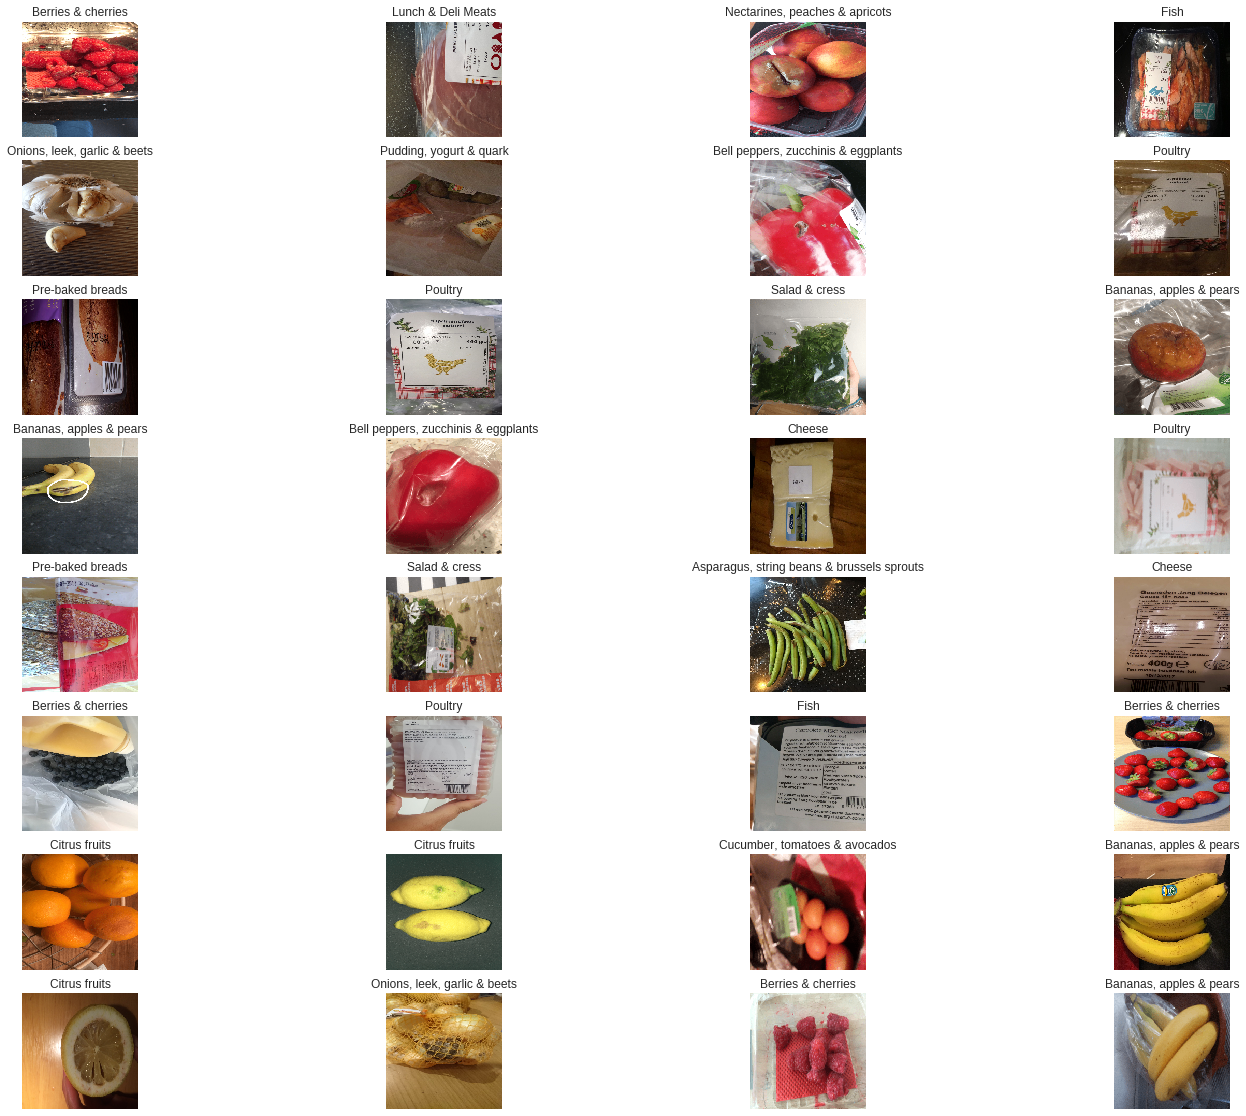

In [0]:
fig = plt.figure(figsize = (25,20))
for i in range(32):
  ax = fig.add_subplot(8,4, i+1, xticks = [], yticks = [])
  ax.imshow(X[i])
  ax.set_title(labels[np.argmax(y[i])])

## Building & Testing Model

In [0]:
# helper functions 
def train_model(model, epochs, name = "model", generator = True):
  early_stopping = EarlyStopping(patience=9)
  checkpointer = ModelCheckpoint(name + 'best.h5', monitor='val_acc', verbose=1, save_best_only=True)
  if generator:
    history = model.fit_generator(train_generator, epochs= epochs, 
                                  steps_per_epoch= step_epochs, 
                                  validation_steps=step_validation, 
                                  validation_data = valid_generator, 
                                  callbacks=[early_stopping, checkpointer])
  else:
    history = model.fit(x_train, y_train, epochs= epochs, batch_size = 32, 
                        validation_data= (x_test,y_test),
                       callbacks=[early_stopping, checkpointer])
  model.load_weights(name + 'best.h5')
  score = model.evaluate_generator(valid_generator, steps = step_validation)
  print('Accuracy of {}%'.format(score[1]*100))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Losses')
  plt.legend()
  plt.show()
  plt.plot(history.history['acc'], label='Training acc')
  plt.plot(history.history['val_acc'], label='Validation acc')
  plt.legend()
  plt.title('Accuracies')
  plt.show()

In [0]:
def train_model_fast(model, epochs, generator = True):
  if generator:
    history = model.fit_generator(train_generator, epochs= epochs, steps_per_epoch= step_epochs)
    score = model.evaluate_generator(valid_generator, steps = step_validation)
  else:
    history = model.fit(X, y, epochs= epochs, batch_size = 64)
    score = model.evaluate(x_test, y_test)
  print('Accuracy of Validation was {}%'.format(score[1]*100))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['acc'], label='Training acc')
  plt.title('Results')
  plt.legend()
  plt.show()

In [0]:
# Building simple model
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))
model.summary()

In [0]:
train_model(model, 10)

In [0]:
# Building some complex models
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', input_shape = (224,224,3), activation = 'relu'))
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation = 'softmax'))
model.summary()

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop' , metrics = ['accuracy'])

In [0]:
train_model(model, 5)

## Transfer Learning

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 
from keras.layers import GlobalAveragePooling2D
from keras import optimizers

## Summary of Pre-Trained Model

In [0]:
# helper function to visualize models 
def show_model(name, weight = 'imagenet', pool = 'avg'):
  
  if name == 'resnet':
    model = ResNet50(include_top=False, weights= weight, pooling= pool)
  if name == 'xception':
    model = Xception(include_top=False, weights= weight, pooling= pool)
  elif name == 'mobilenet':
    model = MobileNetV2(include_top=False, weights= weight, pooling= pool)
  elif name == 'nasnet':
    model = NASNetMobile(include_top=False, weights= weight, pooling= pool)
  elif name == 'nasnet_large':
    model = NASNetLarge(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  elif name == 'densenet121':
    model = DenseNet121(include_top=False, weights= weight, pooling= pool)
    for layer in model.layers[:-115]:
        layer.trainable = False
  elif name == 'densenet169':
    model = DenseNet169(include_top=False, weights= weight, pooling= pool)
  elif name == 'densenet201':
    model = DenseNet201(include_top=False, weights= weight, pooling= pool)
  elif name == 'vgg16':
    model = VGG16(include_top=False, weights= weight, pooling= pool)
  elif name == 'vgg19':
    model = VGG19(include_top=False, weights= weight, pooling= pool)
  elif name == 'inception_v3':
    model = InceptionV3(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  elif name == 'inception_resnet_v3':
    model = InceptionResNetV2(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  
  for layer in model.layers:    
      print("{}, {}".format(type(layer).__name__ , layer.trainable))
  model.summary()

In [36]:
show_model('densenet121')

InputLayer, False
ZeroPadding2D, False
Conv2D, False
BatchNormalization, False
Activation, False
ZeroPadding2D, False
MaxPooling2D, False
BatchNormalization, False
Activation, False
Conv2D, False
BatchNormalization, False
Activation, False
Conv2D, False
Concatenate, False
BatchNormalization, False
Activation, False
Conv2D, False
BatchNormalization, False
Activation, False
Conv2D, False
Concatenate, False
BatchNormalization, False
Activation, False
Conv2D, False
BatchNormalization, False
Activation, False
Conv2D, False
Concatenate, False
BatchNormalization, False
Activation, False
Conv2D, False
BatchNormalization, False
Activation, False
Conv2D, False
Concatenate, False
BatchNormalization, False
Activation, False
Conv2D, False
BatchNormalization, False
Activation, False
Conv2D, False
Concatenate, False
BatchNormalization, False
Activation, False
Conv2D, False
BatchNormalization, False
Activation, False
Conv2D, False
Concatenate, False
BatchNormalization, False
Activation, False
Conv2D, 

## Training of Model

In [0]:
# helper method to freeze a model
def freeze_model(model, freeze, upto = None):
    if freeze:
      if upto:
        for layer in model.layers[:upto]:
            layer.trainable = False
      else:
        for layer in model.layers:
            layer.trainable = False
    return model

In [0]:
# helper function to creat models 
def make_model(name, weight = 'imagenet', upto = None, freeze = False, pool = 'avg'):
  model = Sequential()
  if name == 'resnet':      
    model.add(freeze_model(ResNet50(include_top=False, weights= weight, pooling= pool), freeze, upto))
  if name == 'xception':
    model.add(freeze_model(Xception(include_top=False, weights= weight, pooling= pool), freeze, upto))
  elif name == 'mobilenet':
    model.add(freeze_model(MobileNetV2(include_top=False, weights= weight, pooling= pool), freeze))
  elif name == 'densenet121':
    dense = DenseNet121(include_top=False, weights= weight, pooling= pool)
    model.add(freeze_model(dense, freeze, upto))
  elif name == 'densenet169':
    model.add(freeze_model(DenseNet169(include_top=False, weights= weight, pooling= pool), freeze, upto))
  elif name == 'densenet201':
    model.add(freeze_model(DenseNet201(include_top=False, weights= weight, pooling= pool), freeze, upto))
  elif name == 'vgg16':
    vgg_conv = VGG16(include_top=False, weights= weight, pooling= pool)
    model.add(freeze_model(vgg_conv, freeze, upto))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
  elif name == 'vgg19':
    model.add(freeze_model(VGG19(include_top=False, weights= weight, pooling= pool), freeze, upto))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
  elif name == 'inception_v3':
    incpetion = InceptionV3(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
    model.add(freeze_model(incpetion, freeze, upto))
  elif name == 'inception_resnet_v3':
    model.add(freeze_model(InceptionResNetV2(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool), freeze))
  elif name == 'nasnet':
    model.add(freeze_model(NASNetMobile(include_top=False, weights= weight, pooling= pool), freeze, upto))
  elif name == 'nasnet_large':
    model.add(freeze_model(NASNetLarge(include_top=False, weights= weight, input_shape=(224,224,3), pooling = pool), freeze))
  
  #model.add(Dense(1024, activation='relu'))
  #model.add(Dropout(0.5))
  #model.add(Dense(512, activation = 'relu'))
  #model.add(Dropout(0.25))
  model.add(Dense(25, activation = 'softmax'))
  model.summary()
  
  model.compile(loss = 'categorical_crossentropy', optimizer = "adam" , metrics = ['accuracy'])
  
  return model   

In [38]:
model = make_model('densenet121', freeze = True, pool = 'avg', upto = -20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_5 (Dense)              (None, 25)                25625     
Total params: 7,063,129
Trainable params: 392,537
Non-trainable params: 6,670,592
_________________________________________________________________


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


91/91 [==============================] - 275s 3s/step - loss: 1.8617 - acc: 0.4901
Epoch 2/10
91/91 [==============================] - 248s 3s/step - loss: 1.0793 - acc: 0.6965
Epoch 3/10
91/91 [==============================] - 243s 3s/step - loss: 0.8573 - acc: 0.7604
Epoch 4/10
91/91 [==============================] - 236s 3s/step - loss: 0.6973 - acc: 0.8063
Epoch 5/10
91/91 [==============================] - 247s 3s/step - loss: 0.5906 - acc: 0.8296
Epoch 6/10
91/91 [==============================] - 242s 3s/step - loss: 0.5279 - acc: 0.8463
Epoch 7/10
91/91 [==============================] - 247s 3s/step - loss: 0.4619 - acc: 0.8685
Epoch 8/10
91/91 [==============================] - 240s 3s/step - loss: 0.3884 - acc: 0.8907
Epoch 9/10
91/91 [==============================] - 244s 3s/step - loss: 0.3583 - acc: 0.8976
Epoch 10/10
91/91 [==============================] - 241s 3s/step - loss: 0.3196 - acc: 0.9073
Accuracy of Validation was 66.66666666666666%


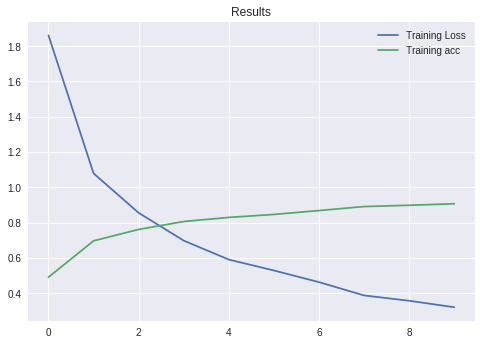

In [40]:
train_model_fast(model, 10)

## Exporting Results

In [0]:
files = glob.glob(path_to_folder + 'test/*')

In [0]:
results = []
i = 0
for file in files:
    print(i)
    i+=1
    img = cv2.imread(file,1)
    img = cv2.resize(img, (224, 224)) 
    img = img/255
    result = model.predict([[img]])
    label = labels[np.argmax(result)]
    filename = os.path.basename(file)
    results.append([filename, label])


In [0]:
headers = ['file', 'label']
df = pd.DataFrame(results, columns=headers)

In [0]:
df = df.sort_values(['file'])

In [0]:
df.head()

,file,label
503,7263.jpeg,"Bell peppers, zucchinis & eggplants"
520,7264.jpeg,Eggs
571,7265.jpeg,"Broccoli, cauliflowers, carrots & radish"
332,7266.png,"Bell peppers, zucchinis & eggplants"
513,7267.jpeg,"Bell peppers, zucchinis & eggplants"


In [0]:
df.to_csv("resnet_3epoch_fasitai.tsv", sep ='\t', index = False)

In [0]:
model.save_weights(path_to_folder + 'pinic_xception_upto12_71_2_3epoch.h5')

In [0]:
true = pd.read_excel('test_5.xlsx')
arr = true.iloc[:,1].values
arr2 = df.iloc[:,1].values
(arr == arr2).mean()

0.5670731707317073

In [0]:
from sklearn.metrics import f1_score
nn = pd.merge(df.iloc[:,[0,1]],true.iloc[:,[0,1]] ,on = 'file')
nn.isnull().sum()
nn.head()
r = nn.dropna(axis = 0)
y_a = r.iloc[:,1].values
y_b = r.iloc[:,2].values
f1_score(y_a, y_b, average = 'macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.4977811623260455

In [0]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(11, 11), activation='relu', 
                 input_shape=(224,224,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(9, 9), activation='relu'))
model.add(Conv2D(64, kernel_size=(9, 9), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation='softmax'))



model.summary()

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [0]:
hist = model.fit(X,y, epochs = 20, validation_data= (x_test,y_test), batch_size=64)

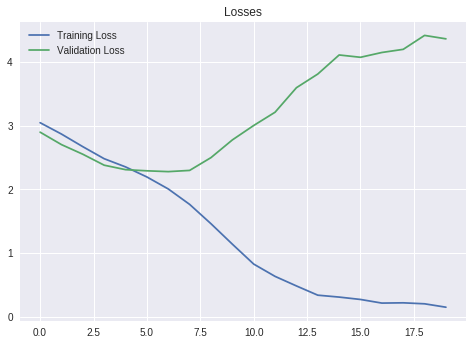

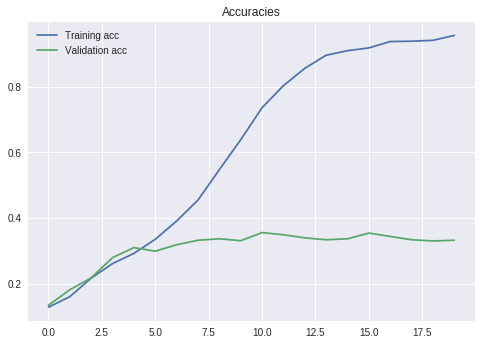

In [0]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Losses')
plt.legend()
plt.show()
plt.plot(hist.history['acc'], label='Training acc')
plt.plot(hist.history['val_acc'], label='Validation acc')
plt.legend()
plt.title('Accuracies')
plt.show()

In [0]:
input_shape = (224,224,3)

In [0]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 25088)             14714688  
_________________________________________________________________
dense_13 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 25)                12825     
Total params: 27,835,737
Trainable params: 13,121,049
Non-trainable params: 14,714,688
_______________________________________________________

In [0]:
hist = model.fit(X,y, epochs = 20, validation_data= (x_test,y_test), batch_size=64)

Train on 5879 samples, validate on 1379 samples
Epoch 1/20
5879/5879 [==============================] - 85s 14ms/step - loss: 3.2806 - acc: 0.0842 - val_loss: 3.2183 - val_acc: 0.1051
Epoch 2/20
5879/5879 [==============================] - 66s 11ms/step - loss: 3.2297 - acc: 0.0356 - val_loss: 3.2189 - val_acc: 0.0174
Epoch 3/20
5879/5879 [==============================] - 66s 11ms/step - loss: 3.2261 - acc: 0.0204 - val_loss: 3.2189 - val_acc: 0.0174
Epoch 4/20
5879/5879 [==============================] - 66s 11ms/step - loss: 3.2335 - acc: 0.0213 - val_loss: 3.2189 - val_acc: 0.0174
Epoch 5/20
5879/5879 [==============================] - 66s 11ms/step - loss: 3.2224 - acc: 0.0199 - val_loss: 3.2131 - val_acc: 0.0174
Epoch 6/20
5824/5879 [============================>.] - ETA: 0s - loss: 3.3182 - acc: 0.0180

In [39]:
slice(3e-5,3e-4)

slice(3e-05, 0.0003, None)